#### Note: This note book is the POC of the concept and used data is publically available.

In [2]:
# Author: Mohammad Nishat Hussain
# for the below example I have used: 
#     OCR: self hosted  https://github.com/mindee/doctr
#     self self hosted  open-source LLM (LLama2 model)

In [3]:
# Objective of below example is to leverage technology and build a SCALABLE 
# solution to verify customer data from submitted documents and also collect 
# more information from it.
# To achive above I have used open source models such as doctr for OCR 
# (Optical charracter recognition) and LLMs to interpret and get json 
# formatted text output. 


## Step1: get OCR

In [88]:
import os, re, requests

In [77]:
!wget -O sample.jpg https://user-images.githubusercontent.com/25701626/27998172-45888cfe-6526-11e7-9b12-67f1b5492670.jpeg

--2023-08-07 20:42:48--  https://user-images.githubusercontent.com/25701626/27998172-45888cfe-6526-11e7-9b12-67f1b5492670.jpeg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13405 (13K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  13.09K  --.-KB/s    in 0.001s  

2023-08-07 20:42:49 (23.5 MB/s) - ‘sample.jpg’ saved [13405/13405]



In [89]:
[file for file in os.listdir('.') if file.lower().endswith(".jpg")]
# !ls

['sample.jpg']

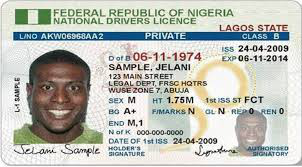

In [90]:
from PIL import Image
file="sample.jpg"
img=Image.open(file);#img=img.resize((400,300))
img

In [91]:
import requests, re
def get_ocr(file=file):
    with open(file, 'rb') as f:
        data = f.read(); txtdata=''
        out=requests.post("http://34.254.172.62:8501/ocr", files={'file': data})
        print(out)
        for box in out.json():
            txtdata+=' '+box['value']
    return txtdata, out

In [92]:
ocr_txt,out=get_ocr()
print(ocr_txt)

<Response [200]>
 FEDERALI REPUBLICOF NIGERIA NATONALI DRIVERSLICENCE LAGOSSTATE LNO AKWO6968AA2 PRIVATE CLASSB IS 24-04-2009 EXP06-11-2014 Dor806-11-1974 SAMPLE,JELANT 231 MAIN STREET LEGALL DEPA FRSC HOTRS WUSEZONEY,ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK 000-000-0000 DATEL OF1stIsS 24-04-2009 Jelan Sample HOLDER mtira - - - SICNATORY SIGNATURE


## Step2: GET document type and Country  (needed to ask Questions to language model Llama2)

In [22]:
ocr_txt="FEDERALI REPUBLICOF NIGERIA NATONALI DRIVERSLICENCE LAGOSSTATE LNO AKWO6968AA2 PRIVATE CLASSB IS 24-04-2009 EXP06-11-2014 Dor806-11-1974 SAMPLE,JELANT 231 MAIN STREET LEGALL DEPA FRSC HOTRS WUSEZONEY,ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK 000-000-0000 DATEL OF1stIsS 24-04-2009 Jelan Sample HOLDER mtira - - - SICNATORY SIGNATURE"

In [23]:
ocr_txt="OCR_TEXT =\"\"\""+ocr_txt+"\"\"\""
prompt ='''Answer below asked questions in a JSON format using OCR_TEXT given below.\n \
1. Classify the given OCR_TEXT data into one of the document categories  \
'driving license', 'education certificate', "voter ID card",'bank document', 'emirates ID card', 'eVisa/Visa/Employement Visa', 'passport', 'national identity card' \
or NULL (If not available) \n \
2. Country of origin of the document (If not available return NULL) \
Return above asked questions in a JSON. \n \
expected output: {"document_type":"value" , "country": 'value'}
" '''+ocr_txt
prompt_template=f''' SYSTEM: You are a helpful AI assistant who give response in a JSON.
USER: {prompt}

ASSISTANT:
'''
print(prompt_template)

 SYSTEM: You are a helpful AI assistant who give response in a JSON.
USER: Answer below asked questions in a JSON format using OCR_TEXT given below.
 1. Classify the given OCR_TEXT data into one of the document categories  'driving license', 'education certificate', "voter ID card",'bank document', 'emirates ID card', 'eVisa/Visa/Employement Visa', 'passport', 'national identity card' or NULL (If not available) 
 2. Country of origin of the document (If not available return NULL) Return above asked questions in a JSON. 
 expected output: {"document_type":"value" , "country": 'value'}
" OCR_TEXT ="""FEDERALI REPUBLICOF NIGERIA NATONALI DRIVERSLICENCE LAGOSSTATE LNO AKWO6968AA2 PRIVATE CLASSB IS 24-04-2009 EXP06-11-2014 Dor806-11-1974 SAMPLE,JELANT 231 MAIN STREET LEGALL DEPA FRSC HOTRS WUSEZONEY,ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK 000-000-0000 DATEL OF1stIsS 24-04-2009 Jelan Sample HOLDER mtira - - - SICNATORY SIGNATURE"""

ASSISTANT:



In [24]:
def get_type_country(prompt_template=prompt_template):
    URL= "http://3.249.145.236:8501/completion"
    data = { "prompt":prompt_template, "n_predict":-1, "temperature":.8, "n_keep":0, "repeat_penalty":1.2 }
    json_pattern = r'{\s*[^}]*\s*}'
    response = requests.post(URL, json=data)
    print(response.json()['content'])
    if response.status_code == 200:
        try:
            matches = re.findall(json_pattern, response.json()['content'], re.DOTALL)
            all_matches = [match.replace('\n','') for match in matches]
            return all_matches, response.json()['content']
        except:
            pass
    else:
        return None, response.json()['content']
country_doc_json, ocr_json=get_type_country()


{
 "document_type": "driving license",
 "country": {
   "code": "NG",
   "name": "Nigeria"
 }
}


### output is country and document type

In [25]:
country_doc_json

['{ "document_type": "driving license", "country": {   "code": "NG",   "name": "Nigeria" }']

## Step3: extract information using speciliased promt for each country and doc_type using LLM (Llama2)

In [26]:
# prompt for County='Nigeria' and document_type='Driving license'
prompt =ocr_txt+'''\nAnswer below questions using given OCR_TEXT data.\n\
1. Name in the driving license?
2. Driving license's issue date?
3. Driving license's expiry date? 
4. Gender?
5. Height of the holder on this licence?
6. What is the driving licence number?
7. Class of vehicle that the holder of this licence is authorized to drive?
8. What is the address mentioned in the driving license?

Return above asked questions in a JSON. \n \
expected output: {"name":"value" , "issue_date": 'value', "expiry_date":'value', "height":'value', 
    "license_number":'value', "gender":'value', "license_class":'value', "address":'value'}
" '''
prompt_template=f''' SYSTEM: You are a helpful AI assistant who read and interpret text input. And give response in a JSON.
USER: {prompt}

ASSISTANT:
'''

print(prompt_template)

 SYSTEM: You are a helpful AI assistant who read and interpret text input. And give response in a JSON.
USER: OCR_TEXT ="""FEDERALI REPUBLICOF NIGERIA NATONALI DRIVERSLICENCE LAGOSSTATE LNO AKWO6968AA2 PRIVATE CLASSB IS 24-04-2009 EXP06-11-2014 Dor806-11-1974 SAMPLE,JELANT 231 MAIN STREET LEGALL DEPA FRSC HOTRS WUSEZONEY,ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK 000-000-0000 DATEL OF1stIsS 24-04-2009 Jelan Sample HOLDER mtira - - - SICNATORY SIGNATURE"""
Answer below questions using given OCR_TEXT data.
1. Name in the driving license?
2. Driving license's issue date?
3. Driving license's expiry date? 
4. Gender?
5. Height of the holder on this licence?
6. What is the driving licence number?
7. Class of vehicle that the holder of this licence is authorized to drive?
8. What is the address mentioned in the driving license?

Return above asked questions in a JSON. 
 expected output: {"name":"value" , "issue_date": 'value', "expiry_date":'value', "heigh

In [27]:
def get_info(prompt_template=prompt_template):
    URL= "http://3.249.145.236:8501/completion"
    data = { "prompt":prompt_template, "n_predict":-1, "temperature":1, "n_keep":0, "repeat_penalty":1.2 }
    json_pattern = r'{\s*[^}]*\s*}'
    response = requests.post(URL, json=data)
    print(response.json()['content'])
    ## Extract JSON information from the LLM ouptut and varify it. 
    ## (better use Pydantic to extract and verify json)
    if response.status_code == 200:
        try:
            matches = re.findall(json_pattern, response.json()['content'], re.DOTALL)
            all_matches = [match.replace('\n','') for match in matches]
            return all_matches, response.json()['content']
        except:
            pass
    else:
        return None, response.json()['content']
ocr_json, ret=get_info()


Of course! I'd be happy to help you with that. Based on the OCR text you provided, here are the answers to your questions in JSON format:

{
"name": "Jelant Sample",
"issue_date": "24-04-2009",
"expiry_date": "16-11-2014",
"height": "1.75M",
"license_number": "AKWO6968AA2",
"gender": " Male",
"license_class": "Private Class B",
"address": "MAIN STREET LEGALL DEPA FRSC HOTORS WUSEZONEY, ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK"
}


### output ready for ingestion into our database

In [28]:
print(ocr_json)

['{"name": "Jelant Sample","issue_date": "24-04-2009","expiry_date": "16-11-2014","height": "1.75M","license_number": "AKWO6968AA2","gender": " Male","license_class": "Private Class B","address": "MAIN STREET LEGALL DEPA FRSC HOTORS WUSEZONEY, ABUA sex M HT1.75M 1st/SSST FCT Bo: A+ FIMARKSN GLN - REPO REN 0 ENDI M,1 NofK"}']


## Step4: ingest ocr info to redshift table

In [23]:
# redshift table
# doc_name/url, ocr_txt, doc_country, doc_type, json_attributes

## FINISHED